この notebook では、最大の時間発展 $t_K$ と、各時間 $t$ における適切な $n_{\text{step}}$ を求める。

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Add the fourier_learning_ibm package to the path
# This is necessary only when running the notebook in the docker container
import sys, pprint

sys.path.append("/home/jovyan/fourier_learning_ibm/")
pprint.pprint(sys.path)

# This is necessary only when running the notebook in the docker container
%cd fourier_learning_ibm/

['/home/jovyan',
 '/opt/conda/lib/python311.zip',
 '/opt/conda/lib/python3.11',
 '/opt/conda/lib/python3.11/lib-dynload',
 '',
 '/opt/conda/lib/python3.11/site-packages',
 '/home/jovyan/fourier_learning_ibm/']
/home/jovyan/fourier_learning_ibm


In [3]:
import numpy as np
from numpy.linalg import qr
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import time
import networkx as nx
from heisenberg import (
    HeisenbergModel,
    get_graph,
    get_positions,
)
from setup import setup_backend
from heisenberg import HeisenbergModel, get_graph, get_positions
from qiskit import transpile
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import (
    Statevector,
    state_fidelity,
)
import json

In [4]:
import warnings

warnings.filterwarnings("ignore")

### Config backend 

In [5]:
backend_qpu, backend_sim_noiseless, backend_sim_noisy = setup_backend(
    qpu_name="ibm_marrakesh"
)

Using backend QPU: <IBMBackend('ibm_marrakesh')>
Using backend noiseless simulator: AerSimulator('aer_simulator')

NoiseModel:
  Basis gates: ['cz', 'delay', 'for_loop', 'id', 'if_else', 'measure', 'reset', 'rz', 'switch_case', 'sx', 'x']
  Instructions with noise: ['cz', 'id', 'sx', 'reset', 'x', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155

## $n_{\text{step}}$ の上限を決定 (やらなくても良い)

(最大の時間発展 $t_K$ を決める際は、決め打ちで $n_{\text{step}}$ の上限を決めてしまうため、このセクションはやらなくても良い)

2 量子ビットゲートによる fidelity 減少レートにより導出する。具体的には以下のような手順で求める。

1. 回路で生じるエラーは、(SPAM エラーを除けば) 2 量子ビットゲートが支配的であると仮定し、2 量子ビットゲートの個数を数える。実行時はコンパイルされるので、これより少なくなることに注意 (あくまでもここで求めているのは上限)

(下図は $n=8, n_{\text{step}}=1$ の場合)
![hoge](./img/counting_2qubit_gates.jpg)

**GHZ 部分** :

$\text{GHZ}$ と $\text{GHZ}^{\dagger}$ の左右 2 個あるので、
\begin{align*}
\left( \frac{n}{2}-1\right) \times2=n-2
\end{align*}

**$e^{-iHt}$ 部分** :

2 次のトロッターの場合は $H_{\text{odd}}$ が $n_{\text{step}}+1$ 個ある。各 $H_{\text{odd}}=H_{1,2}+H_{3,4}+\cdots H_{n-3, n-2}$ の項数は、 $\frac{n}{2}-1$.

2 次のトロッターの場合は $H_{\text{even}}$ が $n_{\text{step}}$ 個ある。各 $H_{\text{even}}=H_{0,1}+H_{2,3}+\cdots H_{n-2, n-1}$ の項数は、 $\frac{n}{2}.$

各 $e^{-iH_{i, i+1}t}$ には、2 個の CNOT が含まれるので、CNOT の個数は
\begin{align*}
2\times\left\{\underbrace{\left(\frac{n}{2}-1\right)(n_{\text{step}}+1)}_{H_{\text{odd}}}+\underbrace{\frac{n}{2}\cdot n_{\text{step}}}_{H_{\text{even}}}\right\} = 2n n_{\text{step}} + n -2n_{\text{step}}-2
\end{align*}

GHZ 部分と $e^{-iHt}$ 部分を合わせて、回路全体の CNOT の個数は
\begin{align*}
(n-2)+2n n_{\text{step}} + n -2n_{\text{step}}-2 = 2\left\{(n-1)(n_{\text{step}}+1)-1\right\}
\end{align*}
以下では、この回路をコンパイルした後の CZ ゲートも同程度の個数であると仮定する。


2. 次に、次に、2 量子ビットゲートのエラー率を求める。これは [IBM の公式サイト](https://quantum.ibm.com/)に CZ の中央値が掲載されており、2025 年 1 月 15 日現在、およそ $\epsilon=0.22$% である。

3. 以上より、 $n_{\text{step}}$ step の回路全体の fidelity は
\begin{align*}
(1-\epsilon)^{2\left\{(n-1)(n_{\text{step}})-1\right\}}.
\end{align*}

上の式より、閾値を fidelity xx 以上と決めれば、$n_{\text{step}}$ の上限が求められる。

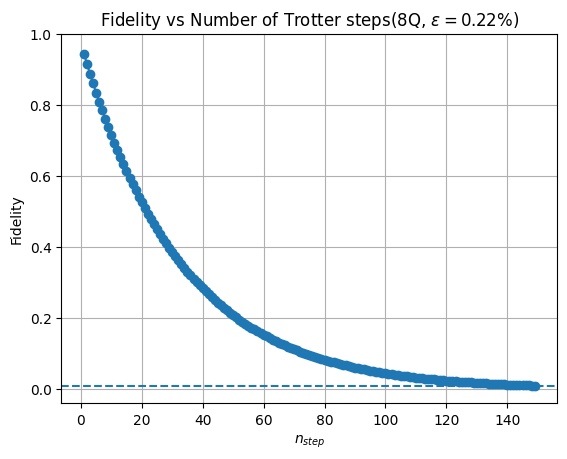

threshold: 0.0100
n_step just before reaching the threshold(0.01): 148
We use this max_n_step=148 for the simulation.


In [ ]:
n_qubits = 4
epsilon = 0.0022

threshold = 0.01
min_n_step_to_check = (
    5  # 最低限この回数だけは確認する. グラフの見栄えを綺麗にするために設定
)
fidelities = []
n_step_counter = 1
flag_threshold = False  # 閾値に達したかどうかのフラグ

while True:
    fidelity = (1 - epsilon) ** (2 * ((n_qubits - 1) * (n_step_counter + 1) - 1))
    fidelities.append(fidelity)
    # print(f"n_step: {n_step}, fidelity: {fidelity}")

    # 閾値に達した場合、その直前の n_counter を n_step とする
    if fidelity < threshold and flag_threshold == False:
        max_n_step = n_step_counter - 1
        flag_threshold = True

    # 閾値に達したとしても、min_n_step_to_check に達していない場合は、そのまま続行
    if fidelity < threshold and n_step_counter >= min_n_step_to_check:
        break
    n_step_counter += 1

plt.plot(range(1, len(fidelities) + 1), fidelities, marker="o")
plt.xlabel(r"$n_{step}$")
plt.ylabel("Fidelity")
plt.grid()
plt.axhline(y=threshold, linestyle="dashed")
plt.ylim(min(fidelities) - 0.05, 1)
plt.title(
    rf"Fidelity vs Number of Trotter steps({n_qubits}Q, $\epsilon={epsilon * 100}$%)"
)
plt.savefig(f"results/get_param/{n_qubits}Q/fidelity_vs_nstep.pdf")
plt.show()

print(f"threshold: {threshold:.4f}")
print(f"n_step just before reaching the threshold({threshold:.2f}): {max_n_step}")
print(rf"We use this max_n_step={max_n_step} for the simulation.")

### Check graph (i.e., Heisenberg Hamiltonian)

今回用いるハミルトニアンは、開放境界条件の 1 次元ハイゼンベルグ模型 : 

\begin{align}
H=\sum_{i=0}^{n-2} J_i\left(X_i X_{i+1}+Y_i Y_{i+1}+Z_i Z_{i+1}\right)
\end{align}

相互作用強度 $J_i$ は $[-1, 1]$ の一様分布からランダムに選ぶ。

これを networkx のグラフとして表す。

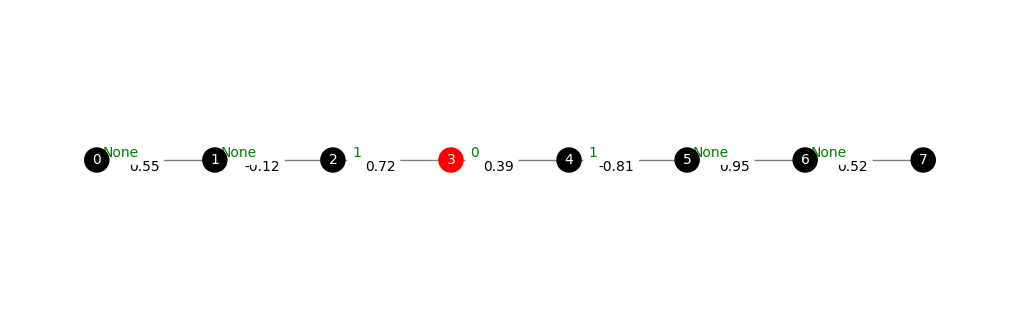

In [8]:
rng = np.random.default_rng(42)
Js = rng.uniform(-1, 1, size=n_qubits - 1)

G = get_graph(n_qubits, Js)
positions = get_positions(n_qubits)

# エッジラベルを作成
edge_J_labels = {edge: f"{G.edges[edge]['J']:.2g}" for edge in G.edges}
edge_cnot_order_labels = {edge: f"{G.edges[edge]['cnot']['order']}" for edge in G.edges}

# グラフを描画
plt.figure(figsize=(10, 3))
nx.draw(
    G,
    pos=positions,
    with_labels=True,
    node_color=["red" if G.nodes[node]["hadamard"] else "black" for node in G.nodes],
    node_size=300,
    edge_color="gray",
    font_color="white",
    font_size=10,
)

# エッジの重みを描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_J_labels,
    font_size=10,
    font_color="black",
    label_pos=0.6,
    verticalalignment="top",
)

# エッジの 'cnot' 'order' 属性を描画
nx.draw_networkx_edge_labels(
    G,
    pos=positions,
    edge_labels=edge_cnot_order_labels,
    font_size=10,
    font_color="green",
    label_pos=0.8,
    verticalalignment="bottom",
)

plt.show()

上の図で、
- 丸はスピンを表し、量子回路を実行するときには量子ビットとしてマップされる
- 赤い丸は、GHZ 部分の最初にアダマールゲートが作用する量子ビットである
- エッジの緑の数字は、GHZ 部分で CNOT が作用する順番である。効率的にエンタングルメントが広がるように、アダマールゲートが作用した量子ゲートから順に CNOT をかけていく。GHZ 部分で用意したい状態は $\ket{00111100}$ (中心半分が 1) なので、CNOT が作用する量子ビットは中心の半分である。'None' はそれ以外、つまり CNOT が作用されず、0 のままであることを表す
- エッジの黒の数字は、相互作用強度 $J_{ij}$ を表す。「ランダムなハミルトニアンを作る」とは、これらの $J_{ij}$ をランダムに作ることを意味する。

## 積公式エラーの計算　(やらなくても良い)

実機ノイズがない状態で、積公式によるエラーを調べる。

In [10]:
times = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] + list(np.arange(10, 200, 5))
results = []

rng = np.random.default_rng(42)
Js = rng.uniform(-1, 1, size=n_qubits - 1)
G = get_graph(n_qubits, Js)
heisenberg = HeisenbergModel(n_qubits, G)

for t in times:
    # initial state
    state_init = Statevector.from_label("0" * n_qubits)

    # Exact simulation (Non-Trotter)
    state_exact, U_exact = heisenberg.exact_simulation(t, phase=0)

    # Trotter simulation
    for n_step in range(0, round(max_n_step / 50) * 50 + 1, 50):  # 50 刻みで計算する
        if n_step == 0:
            n_step = 1

        circuit = heisenberg.get_circuit(t, n_step, phase=0)
        circuit.remove_final_measurements()

        print("preparing U_trotter...")
        U_trotter = Operator.from_circuit(circuit)

        print("processing...")
        state_trotter = state_init.evolve(U_trotter)

        print("calculating fidelity...")
        sta_fidelity = state_fidelity(state_exact, state_trotter)
        print(f"t: {t:.3f}, n_step: {n_step}, fidelity: {sta_fidelity:.3f}")

        results.append(
            {
                "t": t,
                "n_step": n_step,
                "sta_fidelity": sta_fidelity,
            }
        )

preparing U_trotter...
processing...
calculating fidelity...
t: 0.000, n_step: 1, fidelity: 1.000
preparing U_trotter...
processing...
calculating fidelity...
t: 0.000, n_step: 50, fidelity: 1.000
preparing U_trotter...


KeyboardInterrupt: 

,t,n_step,sta_fidelity
0,0,1,1.000000
1,0,50,1.000000
2,0,100,1.000000
3,0,150,1.000000
4,0,200,1.000000
...,...,...,...
379,195,150,0.131933
380,195,200,0.492386
381,195,250,0.379110
382,195,300,0.589373


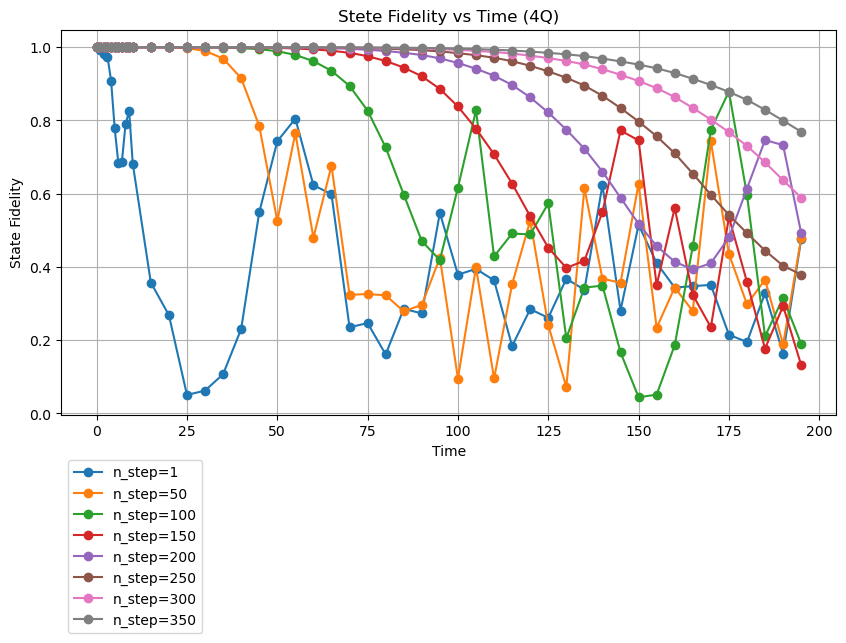

In [ ]:
df = pd.DataFrame(results)
# t と n_step ごとに sta_fidelity をグループ化
df_grouped = df.groupby(["t", "n_step"]).agg({"sta_fidelity": "mean"})
df_grouped = df_grouped.reset_index()
display(df_grouped)

# plot
plt.figure(figsize=(10, 5))
for n_step in df_grouped["n_step"].unique():
    df_tmp = df_grouped[df_grouped["n_step"] == n_step]
    plt.plot(df_tmp["t"], df_tmp["sta_fidelity"], label=f"n_step={n_step}", marker="o")
# random_pro_fidelity = 1 / (2**n_qubits)
# plt.axhline(y=random_pro_fidelity, color="red", linestyle="dashed", label="1/(2**n)")
plt.xlabel("Time")
plt.ylabel("State Fidelity")
plt.legend(bbox_to_anchor=(0, -0.1), loc="upper left")
plt.grid()
plt.title(f"Stete Fidelity vs Time ({n_qubits}Q)")
# plt.savefig(f"results/get_param/{n_qubits}Q/fidelity_vs_time.pdf")
plt.show()

In [ ]:
max_times = {}
threshold = 0.98

# 各 n_step ごとに、threshold を超える最大の time を取得
for n_step in df_grouped["n_step"].unique():
    df_tmp = df_grouped[df_grouped["n_step"] == n_step]
    max_time = df_tmp[df_tmp["sta_fidelity"] > threshold]["t"].max()
    max_times[n_step] = max_time

print(max_times)

## ノイズありシミュレーション

ランダムに複数個作ったハミルトニアンについて、ノイズありの積公式シミュレーションを行う。その後、複数ハミルトニアンについての平均 fidelity が閾値 xx 以上となる最大の $t$ を $t_K$ とする。

おさらいになるが、私たちはハミルトニアン $H$ の関数 $f(H)$ を求めたい。そこで、$f$ を $[-C, C]$ で定義される周期 $2C$ の関数と見てフーリエ級数近似する:
\begin{aligned}
f(x) &\simeq a_0 + \sum_{k=1}^K \left(a_k \cos \frac{k \pi x}{C}+b_k \sin \frac{k \pi x}{C}\right) \\
\therefore \operatorname{Tr}[f(H)\rho]
&\simeq a_0 + \sum_{k=1}^K \left( a_k \operatorname{Re}\left[\operatorname{Tr}\left[e^{-i t_k H} \rho\right]\right] + b_k \operatorname{Im}\left[\operatorname{Tr}\left[e^{-i t_k H} \rho\right]\right] \right) \\
&\qquad \qquad \left(t_k = \frac{k\pi}{C} \right) \\
\end{aligned}

上の式より特徴量の個数は、実部・虚部合わせて $2K+1$ である。またあらゆる (1 次元ハイゼンベルグ) ハミルトニアン $H$ について $C\ge\|H\|$ としたいので、
\begin{aligned}
C=3(n-1) \; \left( \ge 3 \sum_{i=0}^{n-2} |J_i| \ge \|H\| \right)
\end{aligned}
とする。

In [6]:
n_qubits = 4
n_samples = 5
C = 3 * (n_qubits - 1)

if n_qubits == 4:
    n_steps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
    max_time = 20.0
elif n_qubits == 8:
    n_steps = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
    max_time = 10.0
elif n_qubits == 12:
    n_steps = [1, 2, 3, 4, 5, 6, 7, 8]
    max_time = 2.0

# t_k = k * pi / C
times = np.arange(0, max_time, np.pi / C)
print(f"times: {times}\n")
results = []
rng = np.random.default_rng(42)

for i in range(n_samples):
    # 途中経過を表示 + ファイルに保存
    progress_report = f"sample: {i}"
    print(progress_report)
    with open(
        f"results/get_param/temp_progress.txt", "a"
    ) as f:  # 使い回すので temp をつける
        f.write(progress_report + "\n")

    # ハイゼンベルグモデルを生成
    Js = rng.uniform(-1, 1, size=n_qubits - 1)
    G = get_graph(n_qubits, Js)
    heisenberg = HeisenbergModel(n_qubits, G)

    for t in times:
        # initial state
        state_init = Statevector.from_label("0" * n_qubits)

        # Exact simulation (Non-Trotter)
        state_exact, U_exact = heisenberg.exact_simulation(t, phase=0)

        # Trotter simulation
        for n_step in n_steps:
            if n_step == 0:
                n_step = 1

            circuit = heisenberg.get_circuit(t, n_step, phase=0)
            circuit.remove_final_measurements()
            exec_circuit = transpile(circuit, backend_sim_noisy)
            exec_circuit.save_density_matrix()

            start = time.time()
            result = backend_sim_noisy.run(exec_circuit).result()
            state_trotter = result.data()["density_matrix"]
            sta_fidelity = state_fidelity(state_exact, state_trotter)
            end = time.time()
            elapsed_time = end - start

            # 途中経過を表示 + ファイルに保存
            progress_report = f"t: {t:.3f}, n_step: {n_step}, fidelity: {sta_fidelity:.3e}, elapsed_time: {elapsed_time:.3f}[s]\n"
            print(progress_report)
            with open(
                f"results/get_param/temp_progress.txt", "a"
            ) as f:  # 使い回すので temp をつける
                f.write(progress_report + "\n")

            results.append(
                {
                    "sample": i,
                    "t": t,
                    "n_step": n_step,
                    "sta_fidelity": sta_fidelity,
                }
            )

    print()

times: [ 0.          0.34906585  0.6981317   1.04719755  1.3962634   1.74532925
  2.0943951   2.44346095  2.7925268   3.14159265  3.4906585   3.83972435
  4.1887902   4.53785606  4.88692191  5.23598776  5.58505361  5.93411946
  6.28318531  6.63225116  6.98131701  7.33038286  7.67944871  8.02851456
  8.37758041  8.72664626  9.07571211  9.42477796  9.77384381 10.12290966
 10.47197551 10.82104136 11.17010721 11.51917306 11.86823891 12.21730476
 12.56637061 12.91543646 13.26450232 13.61356817 13.96263402 14.31169987
 14.66076572 15.00983157 15.35889742 15.70796327 16.05702912 16.40609497
 16.75516082 17.10422667 17.45329252 17.80235837 18.15142422 18.50049007
 18.84955592 19.19862177 19.54768762 19.89675347]

sample: 0
t: 0.000, n_step: 1, fidelity: 1.000e+00, elapsed_time: 1.230[s]

t: 0.000, n_step: 2, fidelity: 1.000e+00, elapsed_time: 1.304[s]

t: 0.000, n_step: 3, fidelity: 1.000e+00, elapsed_time: 1.165[s]

t: 0.000, n_step: 4, fidelity: 1.000e+00, elapsed_time: 1.132[s]

t: 0.000, n

In [7]:
df = pd.DataFrame(results)
# t と sample と n_step ごとに sta_fidelity をグループ化
df_grouped = df.groupby(["t", "sample", "n_step"]).agg({"sta_fidelity": "mean"})
df_grouped = df_grouped.reset_index()
display(df_grouped)

,t,sample,n_step,sta_fidelity
0,0.000000,0,1,1.000000
1,0.000000,0,2,1.000000
2,0.000000,0,3,1.000000
3,0.000000,0,4,1.000000
4,0.000000,0,5,1.000000
...,...,...,...,...
5795,19.896753,4,16,0.370353
5796,19.896753,4,17,0.398751
5797,19.896753,4,18,0.427753
5798,19.896753,4,19,0.450517


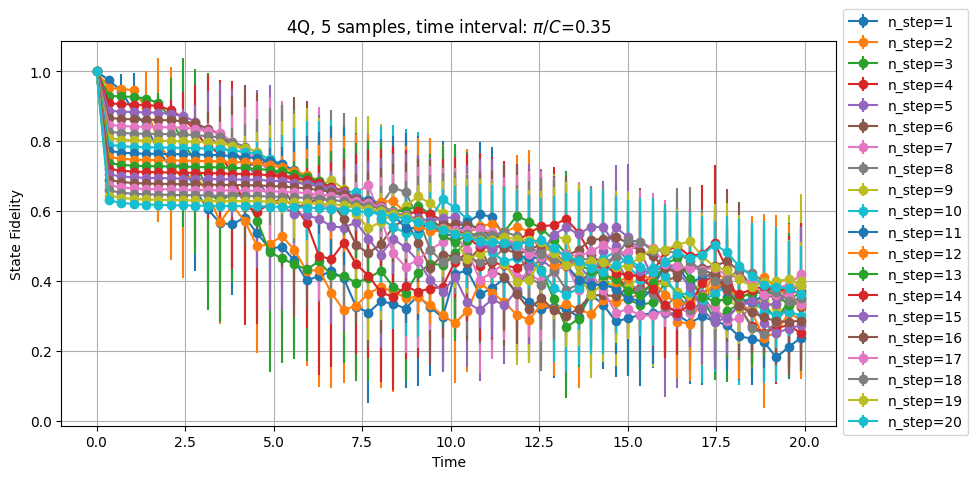

In [8]:
# sta_fidelity の sample に対する平均と分散を計算
df_grouped_mean = df_grouped.groupby(["t", "n_step"]).agg({"sta_fidelity": "mean"})
df_grouped_mean = df_grouped_mean.reset_index()
df_grouped_std = df_grouped.groupby(["t", "n_step"]).agg({"sta_fidelity": "std"})
df_grouped_std = df_grouped_std.reset_index()

# plot
plt.figure(figsize=(10, 5))
for n_step in df_grouped["n_step"].unique():
    df_tmp = df_grouped_mean[df_grouped_mean["n_step"] == n_step]
    plt.errorbar(
        df_tmp["t"],
        df_tmp["sta_fidelity"],
        yerr=df_grouped_std[df_grouped_std["n_step"] == n_step]["sta_fidelity"],
        label=f"n_step={n_step}",
        marker="o",
    )
plt.xlabel("Time")
plt.ylabel("State Fidelity")
plt.legend(bbox_to_anchor=(1, 1.1), loc="upper left")
plt.grid()
plt.title(rf"{n_qubits}Q, {n_samples} samples, time interval: $\pi/C$={np.pi/C:.2f}")
plt.savefig(f"results/get_param/{n_qubits}Q/fidelity_vs_time_rough.pdf")
plt.show()

In [9]:
threshold = 0.80

# df_grouped_mean の sta_fidelity が、いずれの n_step でも threshold を超える最大の time を取得
max_time = df_grouped_mean[df_grouped_mean["sta_fidelity"] > threshold]["t"].max()
print(f"max_time (t_K): {max_time:.2f}")

# max_time 以下の t のみに絞る
df_grouped_mean_reduced = df_grouped_mean[df_grouped_mean["t"] <= max_time]
df_grouped_std_reduced = df_grouped_std[df_grouped_std["t"] <= max_time]

# 絞った各 t において、sta_fidelity の平均が最大となる n_step を取得
df_max_n_step = df_grouped_mean_reduced.loc[
    df_grouped_mean_reduced.groupby("t")["sta_fidelity"].idxmax(),
    ["t", "n_step", "sta_fidelity"],
]
df_max_n_step.reset_index(drop=True, inplace=True)

print(
    f"number of time points: {len(df_max_n_step)}, so K = {len(df_max_n_step) - 1} (except for t=0)"
)
display(df_max_n_step)

# json に保存 (orient="records" で行ごとに保存)
df_max_n_step.to_json(
    f"results/get_param/{n_qubits}Q/threshold{threshold:.2f}/optimal_n_step.json",
    orient="records",
    indent=4,
)

max_time (t_K): 3.49
number of time points: 11, so K = 10 (except for t=0)


,t,n_step,sta_fidelity
0,0.000000,1,1.000000
1,0.349066,1,0.973699
2,0.698132,2,0.949846
3,1.047198,2,0.945106
4,1.396263,3,0.921213
5,1.745329,3,0.909344
6,2.094395,4,0.889045
7,2.443461,5,0.872148
8,2.792527,5,0.856062
9,3.141593,6,0.835667


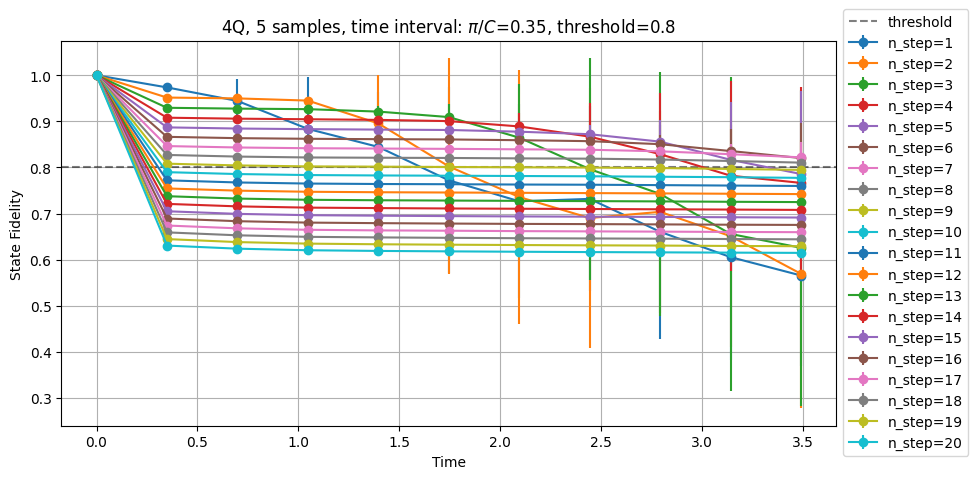

In [10]:
# plot
plt.figure(figsize=(10, 5))
for n_step in df_grouped_mean_reduced["n_step"].unique():
    df_tmp = df_grouped_mean_reduced[df_grouped_mean_reduced["n_step"] == n_step]
    plt.errorbar(
        df_tmp["t"],
        df_tmp["sta_fidelity"],
        yerr=df_grouped_std_reduced[df_grouped_std_reduced["n_step"] == n_step][
            "sta_fidelity"
        ],
        label=f"n_step={n_step}",
        marker="o",
    )
plt.xlabel("Time")
plt.ylabel("State Fidelity")
plt.axhline(
    y=threshold, linestyle="dashed", label="threshold", color="black", alpha=0.5
)
plt.legend(bbox_to_anchor=(1, 1.1), loc="upper left")
plt.grid()
plt.title(
    rf"{n_qubits}Q, {n_samples} samples, time interval: $\pi/C$={np.pi/C:.2f}, threshold={threshold}"
)
plt.savefig(
    f"results/get_param/{n_qubits}Q/threshold{threshold:.2f}/fidelity_vs_time_detail.pdf"
)
plt.show()